# Assignment 6
This assignment is designed to develop your ability to process data sets, use scikit-learn models, and analyze their output. You will do this by classifying, clustering, and analyzing news articles from the BBC.

This will demonstrate the following skills:

* Multi-class (more than 2 classes) classification using naïve Bayes and k-nearest neighbors classifiers
* Clustering with the k-means algorithm
* SciKit pipelines
* Dimensionality reduction with SVD and NMF

## Environment Setup

In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS 
from sklearn.decomposition import TruncatedSVD

## Data
Two news article datasets, originating from BBC News, provided for use as benchmarks for machine learning research.
These datasets are made available for non-commercial and research purposes only, and all data is provided in pre-processed matrix format. If you make use of these datasets please consider citing the publication:

D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006. [PDF] [BibTeX].

All rights, including copyright, in the content of the original articles are owned by the BBC.

Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Class Labels: 5 (business, entertainment, politics, sport, tech)
* Download pre-processed dataset
* Download raw text files

The datasets have been pre-processed as follows: stemming (Porter algorithm), stop-word removal (stop word list) and low term frequency filtering (count < 3) have already been applied to the data. The files contained in the archives given above have the following formats:

*.mtx: Original term frequencies stored in a sparse data matrix in Matrix Market format.
*.terms: List of content-bearing terms in the corpus, with each line corresponding to a row of the sparse data matrix.
*.docs: List of document identifiers, with each line corresponding to a column of the sparse data matrix.
*.classes: Assignment of documents to natural classes, with each line corresponding to a document.
*.urls: Links to original articles, where appropriate.


In [3]:
from pathlib import Path
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text(encoding="latin1"))
     for f in Path("bbc-fulltext/bbc").glob("*/*.txt")),
    columns=["category", "file", "text"]
)

In [4]:
train, test = train_test_split(articles, test_size=0.2, random_state=42)

<AxesSubplot:xlabel='category', ylabel='count'>

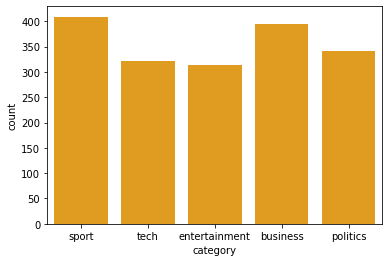

In [5]:
sns.countplot(x="category", data=train, color="orange")

In [6]:
bayes_pipe = Pipeline([
    ('word_count', CountVectorizer(stop_words=ENGLISH_STOP_WORDS)),
    ('classify', MultinomialNB())
])
bayes_pipe.fit(train['text'], train['category'])

prediction = bayes_pipe.predict(train["text"])

In [7]:
print(classification_report(train["category"], prediction))

               precision    recall  f1-score   support

     business       1.00      0.99      0.99       395
entertainment       1.00      1.00      1.00       314
     politics       1.00      1.00      1.00       341
        sport       1.00      1.00      1.00       409
         tech       0.98      1.00      0.99       321

     accuracy                           1.00      1780
    macro avg       1.00      1.00      1.00      1780
 weighted avg       1.00      1.00      1.00      1780



In [8]:
bayes_pipe = Pipeline([
    ('word_count', TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)),
    ('classify', KNeighborsClassifier(n_neighbors=5))
])
bayes_pipe.fit(train['text'], train['category'])

prediction = bayes_pipe.predict(train["text"])

In [9]:
print(classification_report(train["category"], prediction))

               precision    recall  f1-score   support

     business       0.97      0.93      0.95       395
entertainment       0.97      0.95      0.96       314
     politics       0.94      0.98      0.96       341
        sport       0.98      0.98      0.98       409
         tech       0.94      0.95      0.95       321

     accuracy                           0.96      1780
    macro avg       0.96      0.96      0.96      1780
 weighted avg       0.96      0.96      0.96      1780



In [10]:
prediction = bayes_pipe.predict(test["text"])
print(classification_report(test["category"], prediction))


               precision    recall  f1-score   support

     business       0.94      0.88      0.91       115
entertainment       0.99      0.93      0.96        72
     politics       0.86      0.95      0.90        76
        sport       0.95      0.98      0.97       102
         tech       0.95      0.95      0.95        80

     accuracy                           0.93       445
    macro avg       0.94      0.94      0.94       445
 weighted avg       0.94      0.93      0.93       445



In [11]:
searcher = GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': [1, 5, 33, 50],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "brute"],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "p": [1, 2]
}, scoring=make_scorer(accuracy_score))
bayes_pipe = Pipeline([
    ('word_count', TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)),
    ('classify', searcher)
])
bayes_pipe.fit(train['text'], train['category'])

prediction = bayes_pipe.predict(train["text"])

In [12]:
bayes_pipe.named_steps['classify'].best_params_

{'algorithm': 'auto',
 'metric': 'euclidean',
 'n_neighbors': 33,
 'p': 1,
 'weights': 'distance'}

In [13]:
print(classification_report(train["category"], prediction))

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       395
entertainment       1.00      1.00      1.00       314
     politics       1.00      1.00      1.00       341
        sport       1.00      1.00      1.00       409
         tech       1.00      1.00      1.00       321

     accuracy                           1.00      1780
    macro avg       1.00      1.00      1.00      1780
 weighted avg       1.00      1.00      1.00      1780



In [14]:
prediction = bayes_pipe.predict(test["text"])
print(classification_report(test["category"], prediction))


               precision    recall  f1-score   support

     business       0.99      0.87      0.93       115
entertainment       0.98      0.90      0.94        72
     politics       0.82      0.99      0.90        76
        sport       0.98      1.00      0.99       102
         tech       0.93      0.96      0.94        80

     accuracy                           0.94       445
    macro avg       0.94      0.94      0.94       445
 weighted avg       0.95      0.94      0.94       445



In [15]:
svd_pipe = Pipeline([
    ('word_vec', TfidfVectorizer()),
    ('svd', TruncatedSVD(8))
])
svd_pipe.fit(train['text'])
text_vectors = svd_pipe.transform(train['text'])

In [16]:
data=pd.DataFrame(text_vectors)
data["category"] = train["category"]

In [ ]:
train["classmetho"]

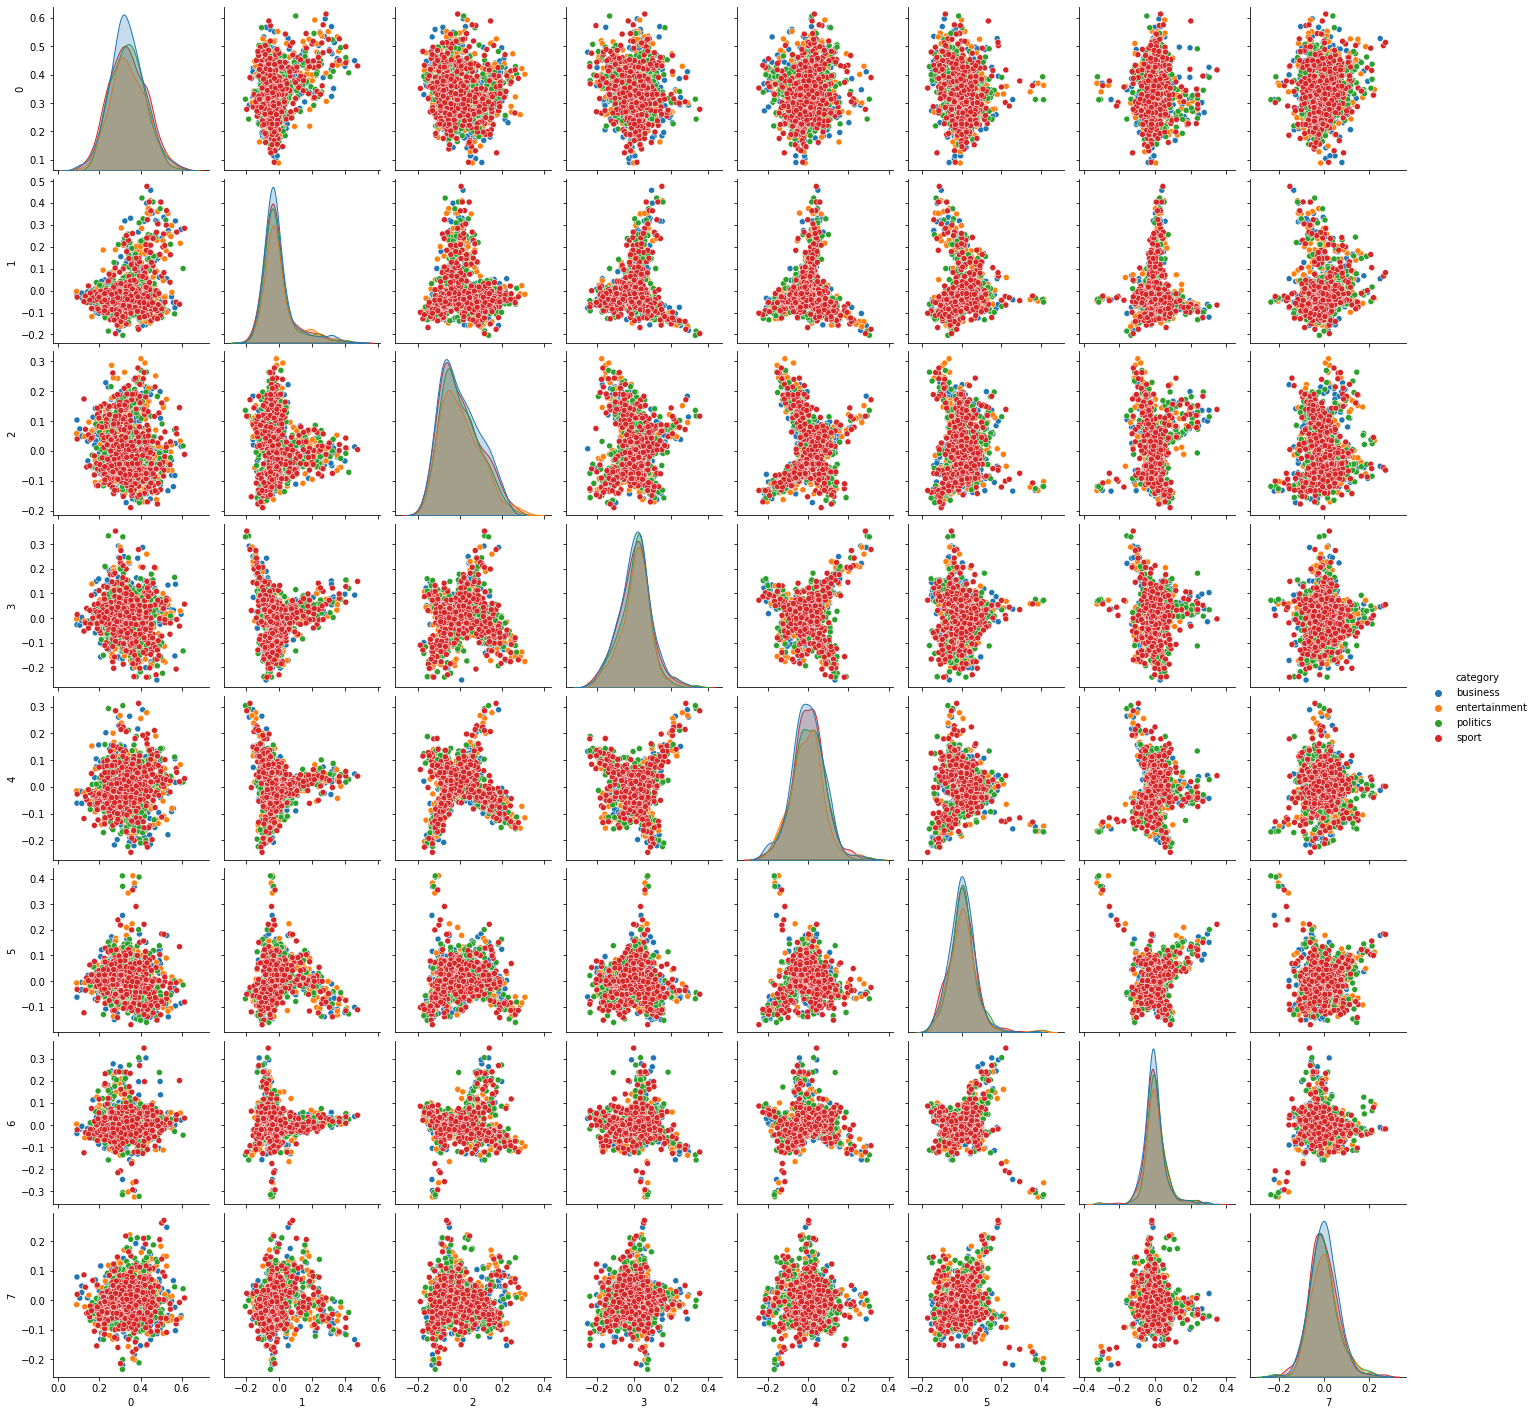

In [17]:
sns.pairplot(data=data, hue="category")

In [18]:
bayes_pipe = Pipeline([
    ('word_count', TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)),
    ('svd', TruncatedSVD(8)),
    ('classify', KNeighborsClassifier(n_neighbors=5, p=1, algorithm="auto", metric="euclidean", weights="distance"))
])
bayes_pipe.fit(train['text'], train['category'])

prediction = bayes_pipe.predict(train["text"])

In [19]:
print(classification_report(train["category"], prediction))

               precision    recall  f1-score   support

     business       1.00      1.00      1.00       395
entertainment       1.00      1.00      1.00       314
     politics       1.00      1.00      1.00       341
        sport       1.00      1.00      1.00       409
         tech       1.00      1.00      1.00       321

     accuracy                           1.00      1780
    macro avg       1.00      1.00      1.00      1780
 weighted avg       1.00      1.00      1.00      1780

